# Making pickle files for bloom timing vs. environmental driver analysis 
### (201905 only)

To work this notebook, change values in the second code cell and rerun for each year.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers

%matplotlib inline

### To recreate this notebook at a different location, only change the following cell:

In [2]:
# Change this to the directory you want the pickle files to be stored:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
# Change 'S3' to the location of interest
loc='QU39'
# To create the time series for a range of years, change iyear to every year within the range
    # and run all cells each time. 
iyear=2020

# Leap years in 'dateslist':
if iyear==2000 or iyear==2004 or iyear==2008 or iyear==2012 or iyear==2016 or iyear==2020:  # leap years: 2020,2016,2012,2008 etc
    dateslist=[[dt.datetime(iyear,1,1),dt.datetime(iyear,1,31)],
               [dt.datetime(iyear,1,31),dt.datetime(iyear,2,29)], 
               [dt.datetime(iyear,2,29),dt.datetime(iyear,4,1)]]
else:
    dateslist=[[dt.datetime(iyear,1,1),dt.datetime(iyear,1,31)],
               [dt.datetime(iyear,1,31),dt.datetime(iyear,2,28)], 
               [dt.datetime(iyear,2,28),dt.datetime(iyear,4,1)]] 

# What is the start year and end year+1 of the time range of interest?
startyear=2007
endyear=2021 # does NOT include this value

# Note: non-location specific variables only need to be done for each year, not for each location
# Note: getWindVars in bloomdrivers would need to be changed?

In [3]:
startjan=dt.datetime(iyear,1,1)  # january start date
endmar=dt.datetime(iyear,4,1)   # march end date (does not include this day)
fraserend=dt.datetime(iyear,3,31) # march end date specifically for Fraser River calculations (includes this day)
forbloomstart=dt.datetime(iyear,2,15) # long time frame to capture spring bloom date
forbloomend=dt.datetime(iyear,6,15)

year=str(iyear)
modver='201905'

fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl' # for location specific variables
fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl' # for non-location specific variables
fname3=f'springBloomTime_{year}_{loc}_{modver}.pkl' # for spring bloom timing calculation
fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl' # for location specific mixing variables
savepath=os.path.join(savedir,fname)
savepath2=os.path.join(savedir,fname2)
savepath3=os.path.join(savedir,fname3)
savepath4=os.path.join(savedir,fname4)
recalc=False

1.1363636363636362

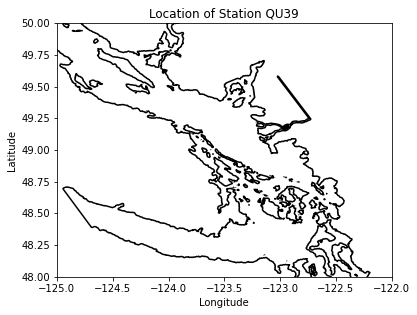

In [4]:
# lat and lon information for place:
lon,lat=places.PLACES[loc]['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES[loc]['NEMO grid ji']
jw,iw=places.PLACES[loc]['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station %s'%loc)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### Creating pickles files for location specific variables:

In [5]:
if recalc==True or not os.path.isfile(savepath):
    basedir='/results2/SalishSea/nowcast-green.201905/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # loads bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    bio_time=list()
    diat_alld=list()
    no3_alld=list()
    flag_alld=list()
    cili_alld=list()
    microzoo_alld=list()
    mesozoo_alld=list()
    intdiat=list()
    intphyto=list()
    spar=list()
    intmesoz=list()
    intmicroz=list()
    grid_time=list()
    temp=list()
    salinity=list()
    u_wind=list()
    v_wind=list()
    twind=list()
    solar=list()
    ik=0
    for ind, datepair in enumerate(dateslist):
        start=datepair[0]
        end=datepair[1]
        flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
        flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
        fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)
        with xr.open_mfdataset(flist['paths']) as bio:
            bio_time.append(np.array([pd.to_datetime(ii)+dt.timedelta(minutes=30) for ii in bio.time_counter.values]))
            no3_alld.append(np.array(bio.nitrate.isel(y=ij,x=ii)))  # 'all_d' = all depths
            diat_alld.append(np.array(bio.diatoms.isel(y=ij,x=ii)))
            flag_alld.append(np.array(bio.flagellates.isel(y=ij,x=ii)))
            cili_alld.append(np.array(bio.ciliates.isel(y=ij,x=ii)))
            microzoo_alld.append(np.array(bio.microzooplankton.isel(y=ij,x=ii)))
            mesozoo_alld.append(np.array(bio.mesozooplankton.isel(y=ij,x=ii)))

            with xr.open_mfdataset(fliste3t['paths']) as carp:
                intdiat.append(np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1))) # 'int' = depth integrated 
                intphyto.append(np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                                +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1)))
                spar.append(np.array(carp.PAR.isel(deptht=ik,y=ij,x=ii))) # surface PAR
                intmesoz.append(np.array(np.sum(bio.mesozooplankton.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)))
                intmicroz.append(np.array(np.sum(bio.microzooplankton.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)))

        with xr.open_mfdataset(flist3['paths']) as grid:
            grid_time.append(np.array([pd.to_datetime(ii)+dt.timedelta(minutes=30) for ii in grid.time_counter.values]))
            temp.append(np.array(grid.votemper.isel(deptht=ik,y=ij,x=ii)) )#surface temperature
            salinity.append(np.array(grid.vosaline.isel(deptht=ik,y=ij,x=ii))) #surface salinity
        
        jW,iW,wopsdir,wnam_fmt=bloomdrivers.getWindVarsYear(iyear,loc)
        if start==dt.datetime(2007,1,1):
            start=dt.datetime(2007,1,3)
        else: 
            pass
        
        flist2=et.index_model_files(start,end,wopsdir,wnam_fmt,flen=1,ftype='None',tres=24)
        with xr.open_mfdataset(flist2['paths']) as winds:
            u_wind.append(np.array(winds.u_wind.isel(y=jW,x=iW)))
            v_wind.append(np.array(winds.v_wind.isel(y=jW,x=iW)))
            twind.append(np.array(winds.time_counter))
            solar.append(np.array(winds.solar.isel(y=jW,x=iW)))
    
    bio_time=np.concatenate(bio_time,axis=0)
    diat_alld=np.concatenate(diat_alld,axis=0)
    no3_alld=np.concatenate(no3_alld,axis=0)
    flag_alld=np.concatenate(flag_alld,axis=0)
    cili_alld=np.concatenate(cili_alld,axis=0)
    microzoo_alld=np.concatenate(microzoo_alld,axis=0)
    mesozoo_alld=np.concatenate(mesozoo_alld,axis=0)
    intdiat=np.concatenate(intdiat,axis=0)
    intphyto=np.concatenate(intphyto,axis=0)
    spar=np.concatenate(spar,axis=0)
    intmesoz=np.concatenate(intmesoz,axis=0)
    intmicroz=np.concatenate(intmicroz,axis=0)
    grid_time=np.concatenate(grid_time,axis=0)
    temp=np.concatenate(temp,axis=0)
    salinity=np.concatenate(salinity,axis=0)
    u_wind=np.concatenate(u_wind,axis=0)
    v_wind=np.concatenate(v_wind,axis=0)
    twind=np.concatenate(twind,axis=0)
    solar=np.concatenate(solar,axis=0)
    
    # Calculations based on saved values:
    no3_30to90m=np.sum(no3_alld[:,22:26]*e3t_0[:,22:26,ij,ii],1)/np.sum(e3t_0[:,22:26,ij,ii]) # average, considering cell thickness
    sno3=no3_alld[:,0] # surface nitrate
    sdiat=diat_alld[:,0] # surface diatoms
    sflag=flag_alld[:,0] # surface flagellates
    scili=cili_alld[:,0] # surface ciliates
    intzoop=intmesoz+intmicroz # depth-integrated zooplankton
    fracdiat=intdiat/intphyto # fraction of depth-integrated phytoplankton that is diatoms
    zoop_alld=microzoo_alld+mesozoo_alld # zooplankton at all depths
    sphyto=sdiat+sflag+scili # surface phytoplankton
    phyto_alld=diat_alld+flag_alld+cili_alld # phytoplankton at all depths
    percdiat=sdiat/sphyto # fraction of surface phytoplankton that is diatoms

    # wind speed:
    wspeed=np.sqrt(u_wind**2 + v_wind**2)
    # wind direction in degrees from east:
    d = np.arctan2(v_wind, u_wind)
    winddirec=np.rad2deg(d + (d < 0)*2*np.pi)
  
    allvars=(bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,
              intdiat,intphyto,spar,intmesoz,intmicroz,
            grid_time,temp,salinity,u_wind,v_wind,twind,solar,
            no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,percdiat,
            wspeed,winddirec)
    pickle.dump(allvars,open(savepath,'wb'))
else:
    pvars=pickle.load(open(savepath,'rb'))
    (bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,
              intdiat,intphyto,spar,intmesoz,intmicroz,
            grid_time,temp,salinity,u_wind,v_wind,twind,solar,
            no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,percdiat,
            wspeed,winddirec)=pvars

### Creating pickles files for location specific mixing variables:

In [6]:
fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl' # for location specific mixing variables
savepath4=os.path.join(savedir,fname4)
if recalc==True or not os.path.isfile(savepath4):
    basedir='/results2/SalishSea/nowcast-green.201905/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    tres=24 # 1: hourly resolution; 24: daily resolution  
    halocline=list() # daily average depth of halocline
    eddy=list() # daily average eddy diffusivity
    flist=et.index_model_files(startjan,endmar,basedir,nam_fmt,flen,"grid_T",tres)
    flist2=et.index_model_files(startjan,endmar,basedir,nam_fmt,flen,"grid_W",1)
    
    for filedate in flist['paths']:
        halocline.append(bloomdrivers.halo_de(filedate,ii,ij))
    
    for day in flist2['paths']:  # this goes through each day and takes the daily average
        with xr.open_dataset(day) as gridw:
            eddy.append(np.mean(np.array(gridw.vert_eddy_diff.isel(y=ij,x=ii)),axis=0))
            depth=np.array(gridw.depthw)
            
    with xr.open_mfdataset(flist['paths']) as gridt:
        grid_time=np.array([pd.to_datetime(ii)+dt.timedelta(minutes=30) for ii in gridt.time_counter.values])
        temp=np.array(gridt.votemper.isel(y=ij,x=ii)) # all depths temperature
        salinity=np.array(gridt.vosaline.isel(y=ij,x=ii)) # all depths salinity  
   
    allvars=(halocline,eddy,depth,grid_time,temp,salinity)
    pickle.dump(allvars,open(savepath4,'wb'))
else:
    pvars=pickle.load(open(savepath4,'rb'))
    (halocline,eddy,depth,grid_time,temp,salinity)=pvars

### Variables for bloom timing calculations

In [7]:
if recalc==True or not os.path.isfile(savepath3):
    basedir='/results2/SalishSea/nowcast-green.201905/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(forbloomstart,forbloomend,basedir,nam_fmt,flen,ftype,tres)
    flist2=et.index_model_files(forbloomstart,forbloomend,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        bio_time0=np.array([pd.to_datetime(ii)+dt.timedelta(minutes=30) for ii in bio.time_counter.values])
        sno30=np.array(bio.nitrate.isel(deptht=ik,y=ij,x=ii))
        sdiat0=np.array(bio.diatoms.isel(deptht=ik,y=ij,x=ii))
        sflag0=np.array(bio.flagellates.isel(deptht=ik,y=ij,x=ii))
        scili0=np.array(bio.ciliates.isel(deptht=ik,y=ij,x=ii))
        no3_alld0=np.array(bio.nitrate.isel(y=ij,x=ii)) 
        diat_alld0=np.array(bio.diatoms.isel(y=ij,x=ii))
        flag_alld0=np.array(bio.flagellates.isel(y=ij,x=ii))
        cili_alld0=np.array(bio.ciliates.isel(y=ij,x=ii))
        with xr.open_mfdataset(flist2['paths']) as carp:
            intdiat0=np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)) # depth integrated diatom
            intphyto0=np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                            +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1))
    fracdiat0=intdiat0/intphyto0 # depth integrated fraction of diatoms

    sphyto0=sdiat0+sflag0+scili0
    phyto_alld0=diat_alld0+flag_alld0+cili_alld0
    percdiat0=sdiat0/sphyto0 # percent diatoms

    pickle.dump((bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0),open(savepath3,'wb'))
else:
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))

### Loops that are not location specific (do not need to be redone for each location):

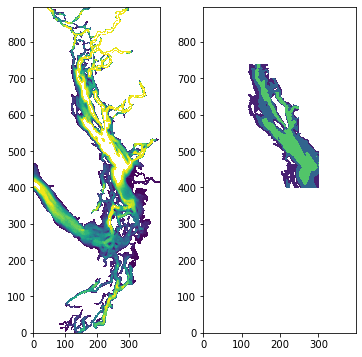

In [8]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

In [9]:
k250=32 # approximate index for 250 m
if recalc==True or not os.path.isfile(savepath2):

    basedir='/results2/SalishSea/nowcast-green.201905/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(startjan,endmar,basedir,nam_fmt,flen,ftype,tres)
    flist3 = et.index_model_files(startjan,endmar,basedir,nam_fmt,flen,"grid_T",tres)
    fliste3t = et.index_model_files(startjan,endmar,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        no3_past250m=np.array(np.sum(np.sum(np.sum(bio.nitrate.isel(deptht=slice(32,40))*sogmask[:,32:,:,:]*e3t_0[:,32:,:,:],3),2),1)\
                /np.sum(sogmask[0,32:,:,:]*e3t_0[0,32:,:,:]))
   
    if iyear !=2020: 
        # reading Fraser river flow files
        dfFra=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Feb-8-2021_06_29_29AM.csv',
                          skiprows=1)
        # the original file contains both flow and water level information in the same field (Value)
        # keep only the flow data, where PARAM=1 (drop PARAM=2 values, water level data)
        # flow units are m3/s
        # DD is YD, year day (ie. 1 is jan 1)
        dfFra.drop(dfFra.loc[dfFra.PARAM==2].index,inplace=True)  

        # rename 'Value' column to 'Flow' now that we have removed all the water level rows
        dfFra.rename(columns={'Value':'Flow'}, inplace=True) 
            # inplace=True does this function on the orginal dataframe

        # no time information so use dt.date
        dfFra['Date']=[dt.date(iyr,1,1)+dt.timedelta(days=idd-1) for iyr, idd in zip(dfFra['YEAR'],dfFra['DD'])]
        # taking the value from the yr column, jan1st date, and making jan1 column to be 1 not 0
        dfFra.head(2)

        # select portion of dataframe in desired date range
        dfFra2=dfFra.loc[(dfFra.Date>=startjan.date())&(dfFra.Date<=fraserend.date())]
        riv_time=dfFra2['Date'].values
        rivFlow=dfFra2['Flow'].values
        # could also write dfFra['Date'], sometimes this is required
        # newstart is a datetime object, so we convert it to just a date with .date
    else: 
        dfFra=pd.read_csv('/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow',sep='\s+',
                  comment='#',names=('Year','Month','Day','Flow'))
        dfFra['Date']=[dt.datetime(int(y),int(m),int(d)) for ind,(y,m,d,f) in dfFra.iterrows()]
        dfFra2=dfFra.loc[(dfFra.Date>=startjan)&(dfFra.Date<=fraserend)]
        riv_time=dfFra2['Date'].values
        rivFlow=dfFra2['Flow'].values
    
    allvars=(no3_past250m,riv_time,rivFlow)
    pickle.dump(allvars,open(savepath2,'wb'))
else:
    pvars=pickle.load(open(savepath2,'rb'))
    (no3_past250m,riv_time,rivFlow)=pvars